In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
 
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import sys
 
saveout = sys.stdout
file = open('variational_autoencoder.txt','w')
sys.stdout = file

In [15]:
#整个网络的维度变化为：784->256->2->256->784
batch_size = 100
original_dim = 784   #28*28
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

In [16]:
#编码器的结构
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
# mean vector
z_mean = Dense(latent_dim)(h)
# standard deviation vector
z_log_var = Dense(latent_dim)(h)

In [17]:
#使用均值变量（mean vector）和标准差变量（standard deviation vector）合成隐变量
def sampling(args):
    z_mean, z_log_var = args
    #使用标准正态分布初始化
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    #合成公式
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
#z即为所要求得的隐含变量
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [18]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
#x_decoded_mean 即为解码器输出的结果
x_decoded_mean = decoder_mean(h_decoded)

In [19]:
#my tips:loss(restruct X)+KL
# Custom loss layer
#自定义损失层，损失包含两个部分：图片的重构误差（均方差Square Loss）以及隐变量与单位高斯分割之间的差异（KL-散度KL-Divergence Loss）。
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss
 
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [20]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.pkl.gz')
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [21]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

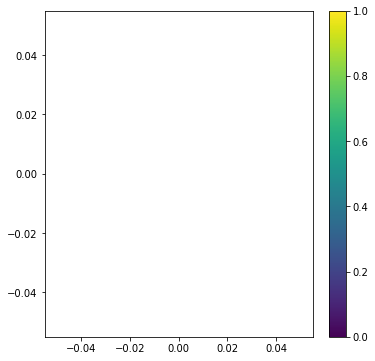

In [22]:
#编码器的网络结构，将输入图形映射为code，即隐含变量
encoder = Model(x, z_mean)
 
#将所有测试集中的图片通过encoder转换为隐含变量（二维变量），并将其在二维空间中进行绘图
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
#构建一个解码器，用于将隐变量解码成图片
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [ ]:
#绘制一个15个图像*15个图像的图
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 生成因变量空间（二维）中的数据，数据满足高斯分布。这些数据构成隐变量，用于图像的生成。
#ppf为累积分布函数（cdf）的反函数，累积分布函数是概率密度函数（pdf）的积分。np.linspace(0.05, 0.95, n)为累计分布函数的输出值（y值），现在我们需要其对应的x值，所以使用cdf的反函数，这些x值构成隐变量。
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
 
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
 
plot(vae,to_file='variational_autoencoder_vae.png',show_shapes=True)
plot(encoder,to_file='variational_autoencoder_encoder.png',show_shapes=True)
plot(generator,to_file='variational_autoencoder_generator.png',show_shapes=True)
 
sys.stdout.close()
sys.stdout = saveout